# **D7041E, Applied Artificial Intelligence - Miniproject**

CHAPIN ALEXANDRE

## ***1. Introduction***
For this Miniproject, I decided to study a problem linked with **computer vision** because this is a field that interests me. The dataset that I chose to study is this one: [Facemask dataset](https://www.kaggle.com/andrewmvd/face-mask-detection). 
In this dataset, we're given a set of 853 pictures of people that wear (or not) masks. All those pictures are annotated and on each picture the different people are separated in bounding box and clasified in one of those 3 categories: with mask, without mask or mask worn incorrectly.

<table>
    <tr>
        <td>
            <img src="0d6c9c64010e4fa78cfd6e1f612ff539_18.webp" width="100%">
        </td>
        <td>
            <img src="covid-19-virus-740-x-360-px-72-dpi-webben.jpg" width="100%">
        </td>
    </tr>
</table>

In the context of Coronavirus, it is mandatory in a majority of countries to wear a mask in public spaces so as to prevent the spread of the disease. It becomes then necessary to track people that don't wear masks or wear it the wrong way so as to warn them on the necessity to wear it and correctly. 
Let's now study our datas.

## ***2. Study of the datas***

In [1]:
import numpy as np
from xml.dom.minidom import parse
from skimage.transform import resize
import glob
from matplotlib import pyplot as plt
from matplotlib import image
from keras.datasets import mnist
from keras.utils import to_categorical

The first step is to know how the datas of the dataset are working. All annotations are in different XML files and the images are stored in another folder. First, I will try to extract the datas from the first XML annotated document and then I will try to crop the linked image with the given datas and associate each cropped image with its label.

In [2]:
# EXAMPLE OF DATA EXTRACTION ON ONE IMAGE

# inspiration: https://www.kaggle.com/issaouisafa/yolov5-facemask-2021

# First, we load the image annotation file
dom = parse("./annotations/maksssksksss0.xml")
root = dom.documentElement

# We extract all the datas corresponding to the image
img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
img_size = root.getElementsByTagName("size")[0]
objects = root.getElementsByTagName("object")
img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
print("img_name:", img_name)
print("image_info:(w,h,c)", img_w, img_h, img_c)


img_box = []
for box in objects:
    cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
    x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
    y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
    x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
    y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
    img_box.append([cls_name, x1, y1, x2, y2])
print(img_box)

img_name: maksssksksss0.png
image_info:(w,h,c) 512 366 3
[['without_mask', 79, 105, 109, 142], ['with_mask', 185, 100, 226, 144], ['without_mask', 325, 90, 360, 141]]


ALL IMAGE:
(366, 512, 3)


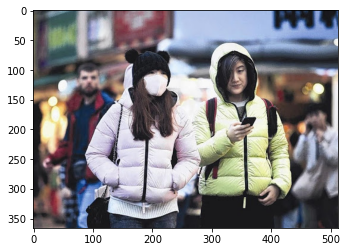


 
 CROP:
without_mask


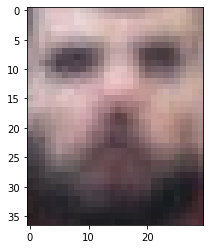

with_mask


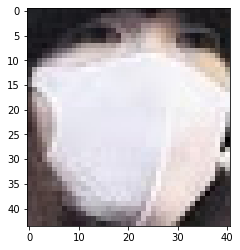

without_mask


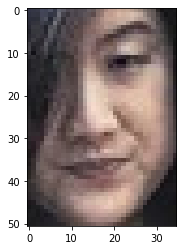

In [3]:
# EXAMPLE OF CROP ON ONE IMAGE:
imagesName = "./images/" + img_name

currentIm = image.imread(imagesName)

print("ALL IMAGE:")
print(currentIm.shape)
plt.imshow(currentIm)
plt.show()

print("\n \n CROP:")
for box in img_box:
    img = currentIm[box[2]:box[4], box[1]:box[3]]
    print(box[0])
    plt.imshow(img)
    plt.show()

Now that I have seen how the datas are working, I will extract all of the datas and put them into arrays to feed our future Neural Network. One thing to mention is that all images haven't the same size or the same depth and it will be a problem for our NN, that's why we have to resize them all at the same size.

## ***3. Preprocessing of the datas***

In [36]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [37]:
# PREPROCESSING OF THE IMAGES
annotationFiles = glob.glob('./annotations/*.xml')
images = []
labels = []
IMAGE_SIZE = 40

for i in range(len(annotationFiles)):
    dom = parse(annotationFiles[i])
    root = dom.documentElement

    # We extract all the datas corresponding to the image
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data

    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        img_box.append([cls_name, x1, y1, x2, y2])
    
    imagePath = "./images/" + img_name 
    currentIm = image.imread(imagePath)
    
    for box in img_box:
        img = currentIm[box[2]:box[4], box[1]:box[3]]
        # We resize the images to put them at the same size
        img_resize = resize(img[...,:3], (IMAGE_SIZE, IMAGE_SIZE))
        #gray = rgb2gray(img_resize)
        #images.append(gray)
        images.append(img_resize)
        # We change the labels into integers
        if box[0] == 'without_mask':
            labels.append(0)
        elif box[0] == 'with_mask':
            labels.append(1)
        else:
            labels.append(2)
        
images_np = np.array(images).astype('float32')
labels_np = np.array(labels)
print(images_np.shape)
print(labels_np.shape)

(4072, 40, 40, 3)
(4072,)


So we finally get a dataset composed of more than 4072 labelled pictures of people

In [38]:
splitSize = 3572
train_X = images_np[:splitSize]
train_Y = labels_np[:splitSize]
test_X = images_np[splitSize:]
test_Y = labels_np[splitSize:]


print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (3572, 40, 40, 3) (3572,)
Testing data shape :  (500, 40, 40, 3) (500,)


Total number of classes :  3
Output classes :  [0 1 2]


Text(0.5, 1.0, 'Class : 1')

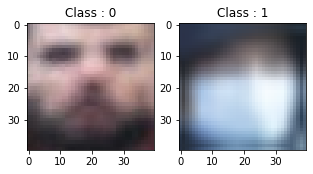

In [39]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of classes : ', nClasses)
print('Output classes : ', classes)

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Class : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Class : {}".format(test_Y[0]))

In [41]:
# Convert images from int8 to float32 and rescale pixel to [0,1]
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

In [42]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0.]


In [43]:
# We split the training data in 2 part: one for the training, another for the validation
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((2857, 40, 40, 3), (715, 40, 40, 3), (2857, 3), (715, 3))

In [44]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

## ***4. Presentation of the model***

The idea that I get to accomplish is to create a Neural Network capable of achieving the classification of the images presented before. I know that CNN (Convolutionnal-Neural Networks) are a very good solution for image classification. I will then try to obtain the better results possible with this neural network by changing parameters and its structure and the final goal would be to be able to do the classification task with pictures of myself.

<img src="cnn.png" width="70%">

A Convolutionnal Neural Network is a Deep-Learning algorithm which can take in an input image, assign importance to various aspects/objects in the image and be able to differentiate one from another. The architecture of a CNN is widely inspired by the Visual Cortex of the Human Brain : individual neurons respond to stimuli only in a restricted region of the visual field. A collection of such fields overlap to cover the entire visual area.

For much details return on this page: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53


#### Convolutionnal Layer
<img src="convolution.gif" width="70%">
On the image above, we can see an animation of the kernel that moves through the image with a certain stride value and this through each channel : convolution operation.
Objective of this operation: extract high-level features such as edges from the input image. 
We can then apply multiple Convolutionnal Layer to capture more details on the image and get a better understanding of the image.

#### Pooling Layer
<img src="pool.gif" width="70%">
Similarly to Convolutional layer, the pooling layer is responsible for reducing the spatial size of the convolved features. It permits to decrease the computational power required to process the data and it is useful to extract dominant features that are rotationnal and positional invariant.
There are two types of Pooling: Max Pooling and Average Pooling. Max pooling returns the maximum value from the portion covered by the kernel. On the other hand, Average pooling returns the average of all the values. 

In general Max pooling performs a lot better than average pooling because it performs as a Noise Suppressant.


The combination of a convolutional layer and a pooling layer forms the i-th layer of a CNN. This number can vary a lot depending on the complexity of the images we study.


#### Classification : Fully Connected Layer
After going through the process of multiple Convolutional/Pooling layers to extract the features we will flatten the output and feed it to a regular NN for classification purpose.
<img src="layers.jpeg" width="70%">

Now that we have converted our input image into a suitable form for out Multi-Level Perceptron, we shall flatten the image into a column vector. 
The flattened output is fed to a feed-forward neural network and backpropagation applied ot every iteration of training. 
Over a series of epochs, the model is able to dinstinguish between dominating and certain low-level features in images and classify them using the Softmax Classification technique.


## ***5. Training phase***

In [45]:
batch_size = 30
epochs = 30
num_classes = 3

In [46]:
maskModel = Sequential()
maskModel.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
maskModel.add(LeakyReLU(alpha=0.1))
maskModel.add(MaxPooling2D((2, 2),padding='same'))
maskModel.add(Dropout(0.25))

maskModel.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
maskModel.add(LeakyReLU(alpha=0.1))
maskModel.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
maskModel.add(Dropout(0.25))

maskModel.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
maskModel.add(LeakyReLU(alpha=0.1))                  
maskModel.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
maskModel.add(Dropout(0.4))

maskModel.add(Flatten())
maskModel.add(Dense(128, activation='linear'))
maskModel.add(LeakyReLU(alpha=0.1))           
maskModel.add(Dropout(0.3))
maskModel.add(Dense(num_classes, activation='softmax'))

In [47]:
maskModel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

## ***6. Testing phase***

In [48]:
maskModelTrain = maskModel.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/30
96/96 [==============================] - 4s 37ms/step - loss: 0.6810 - accuracy: 0.7827 - val_loss: 0.6084 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 4s 38ms/step - loss: 0.6457 - accuracy: 0.7677 - val_loss: 0.5918 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 4s 40ms/step - loss: 0.5804 - accuracy: 0.7750 - val_loss: 0.4283 - val_accuracy: 0.7622
Epoch 4/30
96/96 [==============================] - 4s 44ms/step - loss: 0.3982 - accuracy: 0.7902 - val_loss: 0.2920 - val_accuracy: 0.9021
Epoch 5/30
96/96 [==============================] - 4s 44ms/step - loss: 0.2970 - accuracy: 0.8863 - val_loss: 0.2630 - val_accuracy: 0.9385
Epoch 6/30
96/96 [==============================] - 4s 38ms/step - loss: 0.2418 - accuracy: 0.9275 - val_loss: 0.1984 - val_accuracy: 0.9427
Epoch 7/30
96/96 [==============================] - 4s 44ms/step - loss: 0.2377 - accuracy: 0.9235 - val_loss: 0.2084 - val_accuracy: 0.9371
Epoch 8/30
96

## ***7. Evaluation phase***

In [49]:
test_eval = maskModel.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.19035544991493225
Test accuracy: 0.9300000071525574


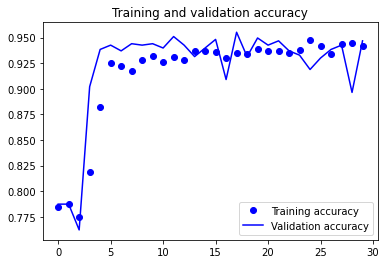

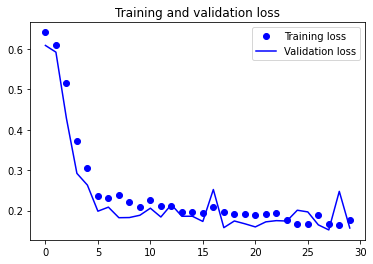

In [50]:
accuracy = maskModelTrain.history['accuracy']
val_accuracy = maskModelTrain.history['val_accuracy']
loss = maskModelTrain.history['loss']
val_loss = maskModelTrain.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [51]:
predicted_classes = maskModel.predict(test_X)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

Found  461  correct labels


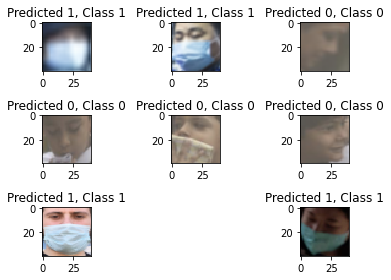

In [55]:
test_X = images_np[splitSize:]
correct = np.where(predicted_classes==test_Y)[0]
print("Found ", len(correct)," correct labels")
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found  39  incorrect labels


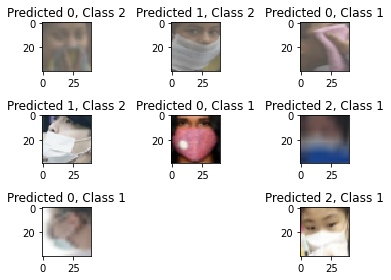

In [56]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found ", len(incorrect)," incorrect labels")
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect], cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

In [54]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.77      0.98      0.86        64
     Class 1       0.97      0.95      0.96       420
     Class 2       0.12      0.06      0.08        16

    accuracy                           0.92       500
   macro avg       0.62      0.66      0.63       500
weighted avg       0.92      0.92      0.92       500



## ***8. Choose the best architecture***
The following article on Kaggle explains a few things about how to change the CNN architecture with the MNIST dataset to obtain better results. We could apply the tips given to our own case.
https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

We've done a first architecture to see the results with this one, they are pretty good but what if we changed the CNN : the number of layers, the size of the layers, or maybe other elements ?
We will do pretty the same idea given in the link above, we will go throught several steps to find the best architecture possible for our dataset.

#### a. How many convolution/subsampling pairs ?
The input images are of size 40x40, after one layer 20x20, after the other 10x10 etc. Because we will in a first time use convolutionnal layers with 24 features and a kernel size of 5x5 followed by a max pooling with a filter of size 2x2 and a stride of 2.
We then won't go further 3 layers because the image would be too much reduced.
Let's try with these different values and compare their computational time and their accuracy

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Step n° 0
Epoch 1/30
96/96 [==============================] - 3s 27ms/step - loss: 0.7129 - accuracy: 0.7586 - val_loss: 0.5985 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 25ms/step - loss: 0.5779 - accuracy: 0.7877 - val_loss: 0.4960 - val_accuracy: 0.7860
Epoch 3/30
96/96 [==============================] - 3s 27ms/step - loss: 0.4658 - accuracy: 0.7783 - val_loss: 0.4061 - val_accuracy: 0.7483
Epoch 4/30
96/96 [==============================] - 2s 25ms/step - loss: 0.4211 - accuracy: 0.7958 - val_loss: 0.3716 - val_accuracy: 0.8056
Epoch 5/30
96/96 [==============================] - 2s 26ms/step - loss: 0.3420 - accuracy: 0.8631 - val_loss: 0.2428 - val_accuracy: 0.9259
Epoch 6/30
96/96 [==============================] - 2s 26ms/step - loss: 0.2556 - accuracy: 0.9253 - val_loss: 0.2240 - val_accuracy: 0.9287
Epoch 7/30
96/96 [==============================] - 3s 26ms/step - loss: 0.2234 - accuracy: 0.9300 - val_loss: 0.2054 - val_accuracy: 0.9329
Epo

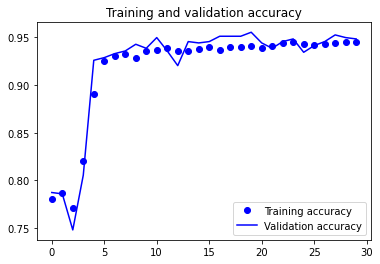

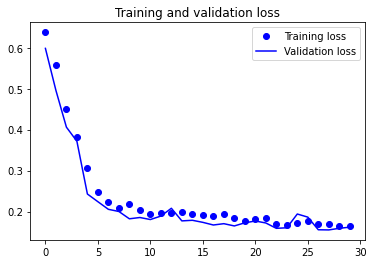

 33%|████████████████████████████                                                        | 1/3 [01:20<02:40, 80.23s/it]

Step n° 1
Epoch 1/30
96/96 [==============================] - 4s 35ms/step - loss: 0.6810 - accuracy: 0.7636 - val_loss: 0.5544 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 3s 34ms/step - loss: 0.5588 - accuracy: 0.7787 - val_loss: 0.4429 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 3s 36ms/step - loss: 0.4284 - accuracy: 0.7867 - val_loss: 0.3496 - val_accuracy: 0.8434
Epoch 4/30
96/96 [==============================] - 3s 36ms/step - loss: 0.3264 - accuracy: 0.8726 - val_loss: 0.2555 - val_accuracy: 0.9315
Epoch 5/30
96/96 [==============================] - 3s 36ms/step - loss: 0.2464 - accuracy: 0.9162 - val_loss: 0.2269 - val_accuracy: 0.9231
Epoch 6/30
96/96 [==============================] - 3s 36ms/step - loss: 0.2110 - accuracy: 0.9364 - val_loss: 0.1923 - val_accuracy: 0.9427
Epoch 7/30
96/96 [==============================] - 3s 35ms/step - loss: 0.1964 - accuracy: 0.9369 - val_loss: 0.2055 - val_accuracy: 0.9259
Epo

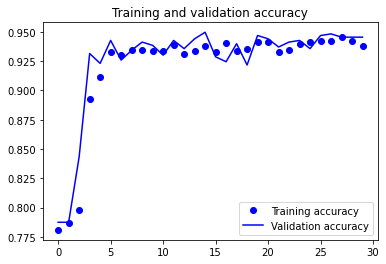

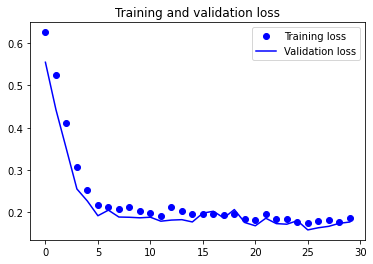

 67%|████████████████████████████████████████████████████████                            | 2/3 [03:09<01:29, 89.09s/it]

Step n° 2
Epoch 1/30
96/96 [==============================] - 4s 40ms/step - loss: 0.7328 - accuracy: 0.7553 - val_loss: 0.5330 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 4s 39ms/step - loss: 0.5298 - accuracy: 0.7995 - val_loss: 0.4497 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 4s 39ms/step - loss: 0.4633 - accuracy: 0.8006 - val_loss: 0.3365 - val_accuracy: 0.8713
Epoch 4/30
96/96 [==============================] - 4s 41ms/step - loss: 0.3428 - accuracy: 0.8812 - val_loss: 0.2688 - val_accuracy: 0.9021
Epoch 5/30
96/96 [==============================] - 4s 38ms/step - loss: 0.2876 - accuracy: 0.9159 - val_loss: 0.2233 - val_accuracy: 0.9315
Epoch 6/30
96/96 [==============================] - 4s 37ms/step - loss: 0.2266 - accuracy: 0.9334 - val_loss: 0.2111 - val_accuracy: 0.9287
Epoch 7/30
96/96 [==============================] - 4s 37ms/step - loss: 0.2378 - accuracy: 0.9209 - val_loss: 0.1979 - val_accuracy: 0.9385
Epo

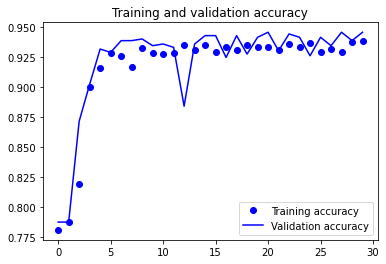

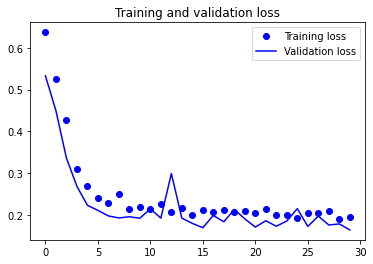

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:54<00:00, 98.15s/it]


In [59]:
from tqdm import tqdm
for j in tqdm(range(3)):
    print("Step n°", j)
    train_X = images_np[:splitSize]
    train_Y = labels_np[:splitSize]
    test_X = images_np[splitSize:]
    test_Y = labels_np[splitSize:]

    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    train_X = train_X / 255.
    test_X = test_X / 255.

    train_Y_one_hot = to_categorical(train_Y)
    test_Y_one_hot = to_categorical(test_Y)

    train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

    batch_size = 30
    epochs = 30
    num_classes = 3

    maskModel = Sequential()
    maskModel.add(Conv2D(36, kernel_size=(5, 5),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
    maskModel.add(MaxPooling2D((2, 2)))
    maskModel.add(Dropout(0.25))
    if(j > 0):
        maskModel.add(Conv2D(72, (5, 5), activation='relu'))
        maskModel.add(MaxPooling2D(pool_size=(2, 2)))
        maskModel.add(Dropout(0.25))
    if(j > 1):
        maskModel.add(Conv2D(144, (5, 5), activation='relu'))
        maskModel.add(MaxPooling2D(pool_size=(2, 2)))
        maskModel.add(Dropout(0.4))

    maskModel.add(Flatten())
    maskModel.add(Dense(256, activation='relu'))
    maskModel.add(Dropout(0.3))
    maskModel.add(Dense(num_classes, activation='softmax'))

    maskModel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    maskModelTrain = maskModel.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
    test_eval = maskModel.evaluate(test_X, test_Y_one_hot, verbose=0)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    accuracy = maskModelTrain.history['accuracy']
    val_accuracy = maskModelTrain.history['val_accuracy']
    loss = maskModelTrain.history['loss']
    val_loss = maskModelTrain.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

**1 Layer** :

    Loss = 0.179836466
    
    Accuracy = 0.93000000
    
    time = 80.23s
    
**2 Layers** :

    Loss = 0.195513889
    
    Accuracy = 0.941999971
    
    time = 89.09s
    
**3 Layers** :

    Loss = 0.201973989
    
    Accuracy = 0.934000015
    
    time = 98.15s
    
    
Better accuracy with 2 layers but a higher loss. For the time, it linearly increase with the number of layers. With 3 layers the solution seems to not be always stable.
We will stay here with 2 layers for the rest of the study.


#### b. How many feature map ?
In the last part, we decided that 2 layers would be sufficient for our problem. Let's now decide on the number of feature map. Let's try 6 different size of layers : 8, 16, 24, 32, 48 and 64. The comparison will be based on the same metrics than before.

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Step n° 8
Epoch 1/30
96/96 [==============================] - 2s 14ms/step - loss: 0.7380 - accuracy: 0.7641 - val_loss: 0.5821 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 1s 12ms/step - loss: 0.5826 - accuracy: 0.7922 - val_loss: 0.5498 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 1s 12ms/step - loss: 0.5385 - accuracy: 0.7828 - val_loss: 0.4319 - val_accuracy: 0.8028
Epoch 4/30
96/96 [==============================] - 1s 12ms/step - loss: 0.4338 - accuracy: 0.7932 - val_loss: 0.3879 - val_accuracy: 0.8434
Epoch 5/30
96/96 [==============================] - 1s 12ms/step - loss: 0.3954 - accuracy: 0.8171 - val_loss: 0.3386 - val_accuracy: 0.8434
Epoch 6/30
96/96 [==============================] - 1s 13ms/step - loss: 0.3007 - accuracy: 0.8974 - val_loss: 0.2256 - val_accuracy: 0.9301
Epoch 7/30
96/96 [==============================] - 1s 13ms/step - loss: 0.2743 - accuracy: 0.9085 - val_loss: 0.1971 - val_accuracy: 0.9441
Epo

 17%|██████████████                                                                      | 1/6 [00:40<03:21, 40.35s/it]

 0.2090446650981903
Test accuracy: 0.921999990940094
Step n° 16
Epoch 1/30
96/96 [==============================] - 3s 24ms/step - loss: 0.7181 - accuracy: 0.7511 - val_loss: 0.5676 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 23ms/step - loss: 0.5439 - accuracy: 0.7902 - val_loss: 0.4386 - val_accuracy: 0.7804
Epoch 3/30
96/96 [==============================] - 2s 24ms/step - loss: 0.4471 - accuracy: 0.7855 - val_loss: 0.4123 - val_accuracy: 0.8028
Epoch 4/30
96/96 [==============================] - 2s 23ms/step - loss: 0.3523 - accuracy: 0.8693 - val_loss: 0.2376 - val_accuracy: 0.9189
Epoch 5/30
96/96 [==============================] - 2s 23ms/step - loss: 0.2423 - accuracy: 0.9245 - val_loss: 0.2107 - val_accuracy: 0.9343
Epoch 6/30
96/96 [==============================] - 2s 18ms/step - loss: 0.2552 - accuracy: 0.9237 - val_loss: 0.2012 - val_accuracy: 0.9343
Epoch 7/30
96/96 [==============================] - 2s 20ms/step - loss: 0.2095 - accuracy

 33%|████████████████████████████                                                        | 2/6 [01:45<03:10, 47.75s/it]

Test loss: 0.19283472001552582
Test accuracy: 0.9259999990463257
Step n° 24
Epoch 1/30
96/96 [==============================] - 3s 29ms/step - loss: 0.6843 - accuracy: 0.7616 - val_loss: 0.5558 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 25ms/step - loss: 0.5242 - accuracy: 0.7945 - val_loss: 0.4380 - val_accuracy: 0.8266
Epoch 3/30
96/96 [==============================] - 3s 28ms/step - loss: 0.4347 - accuracy: 0.8048 - val_loss: 0.3639 - val_accuracy: 0.8503
Epoch 4/30
96/96 [==============================] - 3s 26ms/step - loss: 0.3232 - accuracy: 0.8769 - val_loss: 0.2439 - val_accuracy: 0.9049
Epoch 5/30
96/96 [==============================] - 3s 27ms/step - loss: 0.2396 - accuracy: 0.9239 - val_loss: 0.3864 - val_accuracy: 0.8294
Epoch 6/30
96/96 [==============================] - 3s 27ms/step - loss: 0.2661 - accuracy: 0.9096 - val_loss: 0.1967 - val_accuracy: 0.9413
Epoch 7/30
96/96 [==============================] - 3s 28ms/step - loss: 0.214

 50%|██████████████████████████████████████████                                          | 3/6 [02:53<02:41, 53.95s/it]

Test loss: 0.20267978310585022
Test accuracy: 0.9399999976158142
Step n° 32
Epoch 1/30
96/96 [==============================] - 4s 35ms/step - loss: 0.7134 - accuracy: 0.7646 - val_loss: 0.5613 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 3s 29ms/step - loss: 0.5641 - accuracy: 0.7895 - val_loss: 0.4600 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 3s 30ms/step - loss: 0.4786 - accuracy: 0.7799 - val_loss: 0.3926 - val_accuracy: 0.7972
Epoch 4/30
96/96 [==============================] - 3s 31ms/step - loss: 0.3890 - accuracy: 0.8368 - val_loss: 0.3933 - val_accuracy: 0.8098
Epoch 5/30
96/96 [==============================] - 3s 35ms/step - loss: 0.2832 - accuracy: 0.9041 - val_loss: 0.2034 - val_accuracy: 0.9427
Epoch 6/30
96/96 [==============================] - 3s 31ms/step - loss: 0.2217 - accuracy: 0.9286 - val_loss: 0.2300 - val_accuracy: 0.9091
Epoch 7/30
96/96 [==============================] - 4s 39ms/step - loss: 0.222

 67%|████████████████████████████████████████████████████████                            | 4/6 [04:32<02:14, 67.43s/it]

Test loss: 0.20426489412784576
Test accuracy: 0.9319999814033508
Step n° 48
Epoch 1/30
96/96 [==============================] - 5s 44ms/step - loss: 0.6584 - accuracy: 0.7715 - val_loss: 0.5499 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 4s 42ms/step - loss: 0.5100 - accuracy: 0.7824 - val_loss: 0.4463 - val_accuracy: 0.7706
Epoch 3/30
96/96 [==============================] - 4s 40ms/step - loss: 0.3759 - accuracy: 0.8244 - val_loss: 0.2706 - val_accuracy: 0.8797
Epoch 4/30
96/96 [==============================] - 4s 43ms/step - loss: 0.2286 - accuracy: 0.9190 - val_loss: 0.2005 - val_accuracy: 0.9315
Epoch 5/30
96/96 [==============================] - 4s 42ms/step - loss: 0.2047 - accuracy: 0.9396 - val_loss: 0.1931 - val_accuracy: 0.9343
Epoch 6/30
96/96 [==============================] - 4s 42ms/step - loss: 0.1994 - accuracy: 0.9313 - val_loss: 0.1870 - val_accuracy: 0.9385
Epoch 7/30
96/96 [==============================] - 4s 43ms/step - loss: 0.217

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [06:42<01:26, 86.27s/it]

Test loss: 0.18312278389930725
Test accuracy: 0.9399999976158142
Step n° 64
Epoch 1/30
96/96 [==============================] - 6s 55ms/step - loss: 0.6693 - accuracy: 0.7809 - val_loss: 0.4955 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 5s 56ms/step - loss: 0.4608 - accuracy: 0.8045 - val_loss: 0.3588 - val_accuracy: 0.8168
Epoch 3/30
96/96 [==============================] - 5s 56ms/step - loss: 0.3258 - accuracy: 0.8513 - val_loss: 0.2206 - val_accuracy: 0.9315
Epoch 4/30
96/96 [==============================] - 5s 56ms/step - loss: 0.2173 - accuracy: 0.9255 - val_loss: 0.2985 - val_accuracy: 0.9217
Epoch 5/30
96/96 [==============================] - 5s 56ms/step - loss: 0.2458 - accuracy: 0.9202 - val_loss: 0.1810 - val_accuracy: 0.9441
Epoch 6/30
96/96 [==============================] - 5s 56ms/step - loss: 0.1901 - accuracy: 0.9403 - val_loss: 0.1870 - val_accuracy: 0.9427
Epoch 7/30
96/96 [==============================] - 5s 56ms/step - loss: 0.223

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [09:33<00:00, 95.60s/it]

Test loss: 0.1952534168958664
Test accuracy: 0.9340000152587891


ValueError: x and y must have same first dimension, but have shapes (30,) and (6, 30)

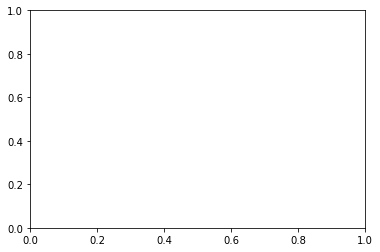

In [61]:
accuracies = []
val_accuracies = []
losses = []
val_losses = []
for j in tqdm([8, 16, 24, 32, 48, 64]):
    print("Step n°", j)
    train_X = images_np[:splitSize]
    train_Y = labels_np[:splitSize]
    test_X = images_np[splitSize:]
    test_Y = labels_np[splitSize:]

    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    train_X = train_X / 255.
    test_X = test_X / 255.

    train_Y_one_hot = to_categorical(train_Y)
    test_Y_one_hot = to_categorical(test_Y)

    train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

    batch_size = 30
    epochs = 30
    num_classes = 3

    maskModel = Sequential()
    maskModel.add(Conv2D(j, kernel_size=(5, 5),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
    maskModel.add(MaxPooling2D((2, 2)))
    maskModel.add(Dropout(0.25))
    
    maskModel.add(Conv2D(j*2, (5, 5), activation='relu'))
    maskModel.add(MaxPooling2D(pool_size=(2, 2)))
    maskModel.add(Dropout(0.25))

    maskModel.add(Flatten())
    maskModel.add(Dense(256, activation='relu'))
    maskModel.add(Dropout(0.3))
    maskModel.add(Dense(num_classes, activation='softmax'))

    maskModel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    maskModelTrain = maskModel.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
    test_eval = maskModel.evaluate(test_X, test_Y_one_hot, verbose=0)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    accuracy = maskModelTrain.history['accuracy']
    accuracies.append(accuracy)
    
    val_accuracy = maskModelTrain.history['val_accuracy']
    val_accuracies.append(val_accuracy)
    
    loss = maskModelTrain.history['loss']
    losses.append(loss)
    val_loss = maskModelTrain.history['val_loss']
    val_losses.append(val_loss)
    

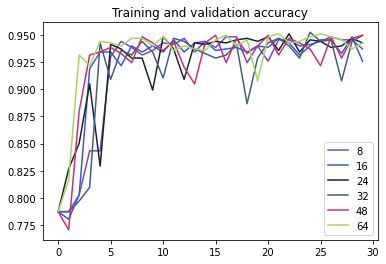

In [88]:
labels = []
for i in [8, 16, 24, 32, 48, 64]:
    labels.append(i)

for i in range(len(accuracies)):
    r = np.random.rand()
    b = np.random.rand()
    g = np.random.rand()
    color = (r, g, b)
    epochs = range(len(accuracies[i]))
    plt.plot(epochs, val_accuracies[i], label='Validation accuracy', c=color)
    plt.legend(labels)
    plt.title('Validation accuracy')


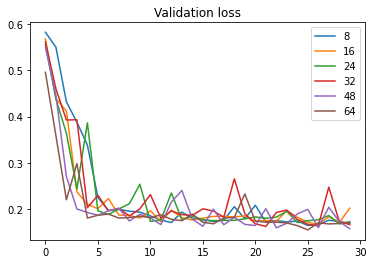

In [90]:
for i in range(len(accuracies)):
    r = np.random.rand()
    b = np.random.rand()
    g = np.random.rand()
    color = (r, g, b)
    epochs = range(len(accuracies[i]))
    plt.plot(epochs, val_losses[i], label='Validation loss')
    plt.legend(labels)
    plt.title('Validation loss')

From our results, it seems that 16 feature maps into our first Convolutionnal Layer and 32 feature maps in the second convolutionnal layer is the best: it combines stability with good results and good computationnal time !

#### c. How large should be the dense layer ?
Now that we have chosen the number of layers and their respective number of maps, let's decide on the number of dense unit we should use for the output layer. We will test those different values: 32, 64, 128, 256, 512, 1024.

In [92]:
accuracies = []
val_accuracies = []
losses = []
val_losses = []
for j in tqdm([32, 64, 128, 256, 512, 1024]):
    print("Step n°", j)
    train_X = images_np[:splitSize]
    train_Y = labels_np[:splitSize]
    test_X = images_np[splitSize:]
    test_Y = labels_np[splitSize:]

    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    train_X = train_X / 255.
    test_X = test_X / 255.

    train_Y_one_hot = to_categorical(train_Y)
    test_Y_one_hot = to_categorical(test_Y)

    train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

    batch_size = 30
    epochs = 30
    num_classes = 3

    maskModel = Sequential()
    maskModel.add(Conv2D(16, kernel_size=(5, 5),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
    maskModel.add(MaxPooling2D((2, 2)))
    maskModel.add(Dropout(0.25))
    
    maskModel.add(Conv2D(32, (5, 5), activation='relu'))
    maskModel.add(MaxPooling2D(pool_size=(2, 2)))
    maskModel.add(Dropout(0.25))

    maskModel.add(Flatten())
    maskModel.add(Dense(j, activation='relu'))
    maskModel.add(Dropout(0.3))
    maskModel.add(Dense(num_classes, activation='softmax'))

    maskModel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    maskModelTrain = maskModel.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
    test_eval = maskModel.evaluate(test_X, test_Y_one_hot, verbose=0)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    accuracy = maskModelTrain.history['accuracy']
    accuracies.append(accuracy)
    
    val_accuracy = maskModelTrain.history['val_accuracy']
    val_accuracies.append(val_accuracy)
    
    loss = maskModelTrain.history['loss']
    losses.append(loss)
    val_loss = maskModelTrain.history['val_loss']
    val_losses.append(val_loss)

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]

Step n° 32
Epoch 1/30
96/96 [==============================] - 2s 19ms/step - loss: 0.7966 - accuracy: 0.7569 - val_loss: 0.5925 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 18ms/step - loss: 0.6050 - accuracy: 0.7933 - val_loss: 0.5531 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 17ms/step - loss: 0.5917 - accuracy: 0.7754 - val_loss: 0.4936 - val_accuracy: 0.7874
Epoch 4/30
96/96 [==============================] - 2s 17ms/step - loss: 0.4976 - accuracy: 0.7846 - val_loss: 0.4261 - val_accuracy: 0.7874
Epoch 5/30
96/96 [==============================] - 2s 17ms/step - loss: 0.4379 - accuracy: 0.7867 - val_loss: 0.3899 - val_accuracy: 0.8210
Epoch 6/30
96/96 [==============================] - 2s 18ms/step - loss: 0.3731 - accuracy: 0.8209 - val_loss: 0.3478 - val_accuracy: 0.8531
Epoch 7/30
96/96 [==============================] - 2s 16ms/step - loss: 0.3677 - accuracy: 0.8540 - val_loss: 0.2635 - val_accuracy: 0.9273
Ep

 17%|██████████████                                                                      | 1/6 [00:51<04:18, 51.79s/it]

Test loss: 0.2049226611852646
Test accuracy: 0.9319999814033508
Step n° 64
Epoch 1/30
96/96 [==============================] - 2s 19ms/step - loss: 0.7377 - accuracy: 0.7561 - val_loss: 0.5838 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 18ms/step - loss: 0.6090 - accuracy: 0.7890 - val_loss: 0.5704 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 18ms/step - loss: 0.5745 - accuracy: 0.7749 - val_loss: 0.4732 - val_accuracy: 0.7874
Epoch 4/30
96/96 [==============================] - 2s 18ms/step - loss: 0.4505 - accuracy: 0.7954 - val_loss: 0.4041 - val_accuracy: 0.7790
Epoch 5/30
96/96 [==============================] - 2s 18ms/step - loss: 0.3905 - accuracy: 0.8162 - val_loss: 0.3419 - val_accuracy: 0.8322
Epoch 6/30
96/96 [==============================] - 2s 18ms/step - loss: 0.3140 - accuracy: 0.8860 - val_loss: 0.3128 - val_accuracy: 0.8587
Epoch 7/30
96/96 [==============================] - 2s 18ms/step - loss: 0.2930

 33%|████████████████████████████                                                        | 2/6 [01:42<03:26, 51.61s/it]

Test loss: 0.2014792263507843
Test accuracy: 0.9319999814033508
Step n° 128
Epoch 1/30
96/96 [==============================] - 2s 18ms/step - loss: 0.7461 - accuracy: 0.7620 - val_loss: 0.5906 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 1s 16ms/step - loss: 0.5909 - accuracy: 0.7845 - val_loss: 0.5157 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 1s 16ms/step - loss: 0.5026 - accuracy: 0.7932 - val_loss: 0.4300 - val_accuracy: 0.7972
Epoch 4/30
96/96 [==============================] - 1s 16ms/step - loss: 0.4351 - accuracy: 0.7994 - val_loss: 0.3621 - val_accuracy: 0.8531
Epoch 5/30
96/96 [==============================] - 2s 16ms/step - loss: 0.3660 - accuracy: 0.8538 - val_loss: 0.2469 - val_accuracy: 0.9203
Epoch 6/30
96/96 [==============================] - 2s 16ms/step - loss: 0.2392 - accuracy: 0.9178 - val_loss: 0.2188 - val_accuracy: 0.9287
Epoch 7/30
96/96 [==============================] - 2s 17ms/step - loss: 0.225

 50%|██████████████████████████████████████████                                          | 3/6 [02:30<02:31, 50.48s/it]

Test loss: 0.19209961593151093
Test accuracy: 0.9340000152587891
Step n° 256
Epoch 1/30
96/96 [==============================] - 2s 19ms/step - loss: 0.7299 - accuracy: 0.7499 - val_loss: 0.5900 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 17ms/step - loss: 0.5912 - accuracy: 0.7869 - val_loss: 0.5214 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 17ms/step - loss: 0.5013 - accuracy: 0.7991 - val_loss: 0.4195 - val_accuracy: 0.8126
Epoch 4/30
96/96 [==============================] - 2s 17ms/step - loss: 0.4314 - accuracy: 0.8085 - val_loss: 0.3174 - val_accuracy: 0.9217
Epoch 5/30
96/96 [==============================] - 2s 17ms/step - loss: 0.3291 - accuracy: 0.8927 - val_loss: 0.2324 - val_accuracy: 0.9203
Epoch 6/30
96/96 [==============================] - 2s 17ms/step - loss: 0.2338 - accuracy: 0.9238 - val_loss: 0.2432 - val_accuracy: 0.9035
Epoch 7/30
96/96 [==============================] - 2s 18ms/step - loss: 0.21

 67%|████████████████████████████████████████████████████████                            | 4/6 [03:24<01:42, 51.49s/it]

Test loss: 0.18615740537643433
Test accuracy: 0.9340000152587891
Step n° 512
Epoch 1/30
96/96 [==============================] - 3s 23ms/step - loss: 0.7200 - accuracy: 0.7619 - val_loss: 0.5832 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 21ms/step - loss: 0.5926 - accuracy: 0.7801 - val_loss: 0.4949 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 21ms/step - loss: 0.4918 - accuracy: 0.7911 - val_loss: 0.4229 - val_accuracy: 0.7776
Epoch 4/30
96/96 [==============================] - 2s 21ms/step - loss: 0.4228 - accuracy: 0.7944 - val_loss: 0.3761 - val_accuracy: 0.8336
Epoch 5/30
96/96 [==============================] - 2s 21ms/step - loss: 0.3623 - accuracy: 0.8286 - val_loss: 0.3315 - val_accuracy: 0.8601
Epoch 6/30
96/96 [==============================] - 2s 21ms/step - loss: 0.2899 - accuracy: 0.8934 - val_loss: 0.3810 - val_accuracy: 0.8308
Epoch 7/30
96/96 [==============================] - 2s 21ms/step - loss: 0.25

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [04:26<00:54, 54.46s/it]

Test loss: 0.200407013297081
Test accuracy: 0.9380000233650208
Step n° 1024
Epoch 1/30
96/96 [==============================] - 3s 26ms/step - loss: 0.6962 - accuracy: 0.7434 - val_loss: 0.5839 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 24ms/step - loss: 0.5571 - accuracy: 0.7839 - val_loss: 0.4326 - val_accuracy: 0.8182
Epoch 3/30
96/96 [==============================] - 2s 24ms/step - loss: 0.4436 - accuracy: 0.8103 - val_loss: 0.3568 - val_accuracy: 0.8615
Epoch 4/30
96/96 [==============================] - 2s 24ms/step - loss: 0.3086 - accuracy: 0.8900 - val_loss: 0.2364 - val_accuracy: 0.9203
Epoch 5/30
96/96 [==============================] - 2s 24ms/step - loss: 0.2170 - accuracy: 0.9282 - val_loss: 0.2705 - val_accuracy: 0.8923
Epoch 6/30
96/96 [==============================] - 2s 24ms/step - loss: 0.2385 - accuracy: 0.9174 - val_loss: 0.2071 - val_accuracy: 0.9259
Epoch 7/30
96/96 [==============================] - 2s 24ms/step - loss: 0.208

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:37<00:00, 56.24s/it]

Test loss: 0.19081631302833557
Test accuracy: 0.9380000233650208


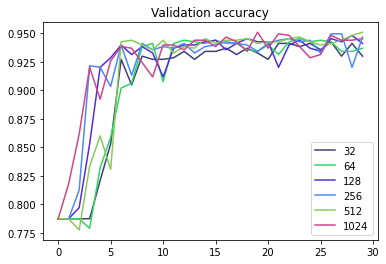

In [95]:
labels = []
for i in [32, 64, 128, 256, 512, 1024]:
    labels.append(i)

for i in range(len(accuracies)):
    r = np.random.rand()
    b = np.random.rand()
    g = np.random.rand()
    color = (r, g, b)
    epochs = range(len(accuracies[i]))
    plt.plot(epochs, val_accuracies[i], label='Validation accuracy', c=color)
    plt.legend(labels)
    plt.title('Validation accuracy')


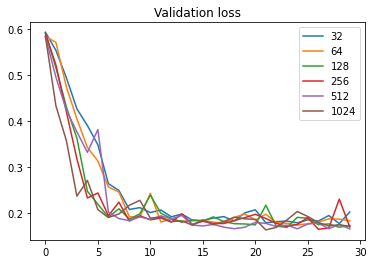

In [96]:
for i in range(len(accuracies)):
    r = np.random.rand()
    b = np.random.rand()
    g = np.random.rand()
    color = (r, g, b)
    epochs = range(len(accuracies[i]))
    plt.plot(epochs, val_losses[i], label='Validation loss')
    plt.legend(labels)
    plt.title('Validation loss')

With the obtained results, it seems that we obtain a better loss/accuracy pair with a Dense layer of Size 512.

#### d. How much dropout ?

Let's finish with one important parameter which is dropout. The dropout will help our network prevent from overfitting and permits it to generalize better. We add a dropout after each layer and we test with those values: 0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%.

In [97]:
accuracies = []
val_accuracies = []
losses = []
val_losses = []
for j in tqdm([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]):
    print("Step n°", j)
    train_X = images_np[:splitSize]
    train_Y = labels_np[:splitSize]
    test_X = images_np[splitSize:]
    test_Y = labels_np[splitSize:]

    train_X = train_X.astype('float32')
    test_X = test_X.astype('float32')
    train_X = train_X / 255.
    test_X = test_X / 255.

    train_Y_one_hot = to_categorical(train_Y)
    test_Y_one_hot = to_categorical(test_Y)

    train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

    batch_size = 30
    epochs = 30
    num_classes = 3

    maskModel = Sequential()
    maskModel.add(Conv2D(16, kernel_size=(5, 5),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
    maskModel.add(MaxPooling2D((2, 2)))
    maskModel.add(Dropout(j))
    
    maskModel.add(Conv2D(32, (5, 5), activation='relu'))
    maskModel.add(MaxPooling2D(pool_size=(2, 2)))
    maskModel.add(Dropout(j))

    maskModel.add(Flatten())
    maskModel.add(Dense(512, activation='relu'))
    maskModel.add(Dropout(j))
    maskModel.add(Dense(num_classes, activation='softmax'))

    maskModel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
    maskModelTrain = maskModel.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))
    test_eval = maskModel.evaluate(test_X, test_Y_one_hot, verbose=0)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    accuracy = maskModelTrain.history['accuracy']
    accuracies.append(accuracy)
    
    val_accuracy = maskModelTrain.history['val_accuracy']
    val_accuracies.append(val_accuracy)
    
    loss = maskModelTrain.history['loss']
    losses.append(loss)
    val_loss = maskModelTrain.history['val_loss']
    val_losses.append(val_loss)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Step n° 0.0
Epoch 1/30
96/96 [==============================] - 2s 21ms/step - loss: 0.7224 - accuracy: 0.7453 - val_loss: 0.5711 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 20ms/step - loss: 0.5367 - accuracy: 0.7996 - val_loss: 0.6681 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 19ms/step - loss: 0.4941 - accuracy: 0.7990 - val_loss: 0.3705 - val_accuracy: 0.8378
Epoch 4/30
96/96 [==============================] - 2s 20ms/step - loss: 0.3486 - accuracy: 0.8395 - val_loss: 0.2880 - val_accuracy: 0.9189
Epoch 5/30
96/96 [==============================] - 2s 21ms/step - loss: 0.2605 - accuracy: 0.9171 - val_loss: 0.2379 - val_accuracy: 0.9273
Epoch 6/30
96/96 [==============================] - 2s 21ms/step - loss: 0.2217 - accuracy: 0.9343 - val_loss: 0.1905 - val_accuracy: 0.9399
Epoch 7/30
96/96 [==============================] - 2s 20ms/step - loss: 0.1949 - accuracy: 0.9306 - val_loss: 0.1778 - val_accuracy: 0.9441
E

 12%|██████████▌                                                                         | 1/8 [01:05<07:40, 65.76s/it]

Test loss: 0.2097804844379425
Test accuracy: 0.921999990940094
Step n° 0.1
Epoch 1/30
96/96 [==============================] - 2s 21ms/step - loss: 0.7330 - accuracy: 0.7597 - val_loss: 0.5922 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 19ms/step - loss: 0.5759 - accuracy: 0.7880 - val_loss: 0.5010 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 19ms/step - loss: 0.5087 - accuracy: 0.7867 - val_loss: 0.3999 - val_accuracy: 0.8266
Epoch 4/30
96/96 [==============================] - 2s 19ms/step - loss: 0.4072 - accuracy: 0.8198 - val_loss: 0.3413 - val_accuracy: 0.8462
Epoch 5/30
96/96 [==============================] - 2s 19ms/step - loss: 0.2912 - accuracy: 0.8997 - val_loss: 0.3615 - val_accuracy: 0.8378
Epoch 6/30
96/96 [==============================] - 2s 19ms/step - loss: 0.3090 - accuracy: 0.8820 - val_loss: 0.1853 - val_accuracy: 0.9413
Epoch 7/30
96/96 [==============================] - 2s 19ms/step - loss: 0.2081

 25%|█████████████████████                                                               | 2/8 [02:01<06:16, 62.71s/it]

Test loss: 0.20485931634902954
Test accuracy: 0.9340000152587891
Step n° 0.2
Epoch 1/30
96/96 [==============================] - 2s 21ms/step - loss: 0.7007 - accuracy: 0.7706 - val_loss: 0.5689 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 3s 27ms/step - loss: 0.5534 - accuracy: 0.7757 - val_loss: 0.4107 - val_accuracy: 0.8280
Epoch 3/30
96/96 [==============================] - 2s 22ms/step - loss: 0.4042 - accuracy: 0.8122 - val_loss: 0.3308 - val_accuracy: 0.8643
Epoch 4/30
96/96 [==============================] - 2s 24ms/step - loss: 0.2907 - accuracy: 0.9046 - val_loss: 0.2052 - val_accuracy: 0.9399
Epoch 5/30
96/96 [==============================] - 2s 25ms/step - loss: 0.2133 - accuracy: 0.9280 - val_loss: 0.2006 - val_accuracy: 0.9357
Epoch 6/30
96/96 [==============================] - 2s 24ms/step - loss: 0.2207 - accuracy: 0.9253 - val_loss: 0.1895 - val_accuracy: 0.9385
Epoch 7/30
96/96 [==============================] - 2s 26ms/step - loss: 0.21

 38%|███████████████████████████████▌                                                    | 3/8 [03:05<05:15, 63.05s/it]

Test loss: 0.18771161139011383
Test accuracy: 0.9359999895095825
Step n° 0.3
Epoch 1/30
96/96 [==============================] - 3s 26ms/step - loss: 0.7357 - accuracy: 0.7486 - val_loss: 0.5795 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 24ms/step - loss: 0.6022 - accuracy: 0.7740 - val_loss: 0.5191 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 19ms/step - loss: 0.5275 - accuracy: 0.7948 - val_loss: 0.4593 - val_accuracy: 0.8378
Epoch 4/30
96/96 [==============================] - 2s 20ms/step - loss: 0.3908 - accuracy: 0.8429 - val_loss: 0.3177 - val_accuracy: 0.8559
Epoch 5/30
96/96 [==============================] - 2s 21ms/step - loss: 0.2753 - accuracy: 0.9035 - val_loss: 0.2381 - val_accuracy: 0.9231
Epoch 6/30
96/96 [==============================] - 2s 21ms/step - loss: 0.2272 - accuracy: 0.9217 - val_loss: 0.2073 - val_accuracy: 0.9343
Epoch 7/30
96/96 [==============================] - 2s 18ms/step - loss: 0.22

 50%|██████████████████████████████████████████                                          | 4/8 [04:07<04:11, 62.79s/it]

Test loss: 0.19654947519302368
Test accuracy: 0.9340000152587891
Step n° 0.4
Epoch 1/30
96/96 [==============================] - 2s 21ms/step - loss: 0.7293 - accuracy: 0.7579 - val_loss: 0.5973 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 23ms/step - loss: 0.5801 - accuracy: 0.7817 - val_loss: 0.4960 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 26ms/step - loss: 0.4707 - accuracy: 0.7888 - val_loss: 0.4064 - val_accuracy: 0.8210
Epoch 4/30
96/96 [==============================] - 2s 24ms/step - loss: 0.4011 - accuracy: 0.8151 - val_loss: 0.3387 - val_accuracy: 0.9189
Epoch 5/30
96/96 [==============================] - 2s 21ms/step - loss: 0.2909 - accuracy: 0.9042 - val_loss: 0.2263 - val_accuracy: 0.9259
Epoch 6/30
96/96 [==============================] - 2s 20ms/step - loss: 0.2378 - accuracy: 0.9253 - val_loss: 0.1974 - val_accuracy: 0.9371
Epoch 7/30
96/96 [==============================] - 2s 19ms/step - loss: 0.23

 62%|████████████████████████████████████████████████████▌                               | 5/8 [05:09<03:07, 62.45s/it]

Test loss: 0.20318812131881714
Test accuracy: 0.9380000233650208
Step n° 0.5
Epoch 1/30
96/96 [==============================] - 3s 22ms/step - loss: 0.6956 - accuracy: 0.7540 - val_loss: 0.5585 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 21ms/step - loss: 0.5514 - accuracy: 0.7836 - val_loss: 0.4698 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 20ms/step - loss: 0.4442 - accuracy: 0.7960 - val_loss: 0.3998 - val_accuracy: 0.8434
Epoch 4/30
96/96 [==============================] - 2s 26ms/step - loss: 0.3712 - accuracy: 0.8350 - val_loss: 0.2785 - val_accuracy: 0.9245
Epoch 5/30
96/96 [==============================] - 2s 22ms/step - loss: 0.2647 - accuracy: 0.9129 - val_loss: 0.2231 - val_accuracy: 0.9273
Epoch 6/30
96/96 [==============================] - 2s 26ms/step - loss: 0.2531 - accuracy: 0.9102 - val_loss: 0.2040 - val_accuracy: 0.9357
Epoch 7/30
96/96 [==============================] - 2s 20ms/step - loss: 0.21

 75%|███████████████████████████████████████████████████████████████                     | 6/8 [06:11<02:04, 62.33s/it]

Test loss: 0.19074924290180206
Test accuracy: 0.9340000152587891
Step n° 0.6
Epoch 1/30
96/96 [==============================] - 3s 22ms/step - loss: 0.7220 - accuracy: 0.7628 - val_loss: 0.5912 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 20ms/step - loss: 0.6047 - accuracy: 0.7811 - val_loss: 0.5342 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 20ms/step - loss: 0.5265 - accuracy: 0.7829 - val_loss: 0.4557 - val_accuracy: 0.8280
Epoch 4/30
96/96 [==============================] - 2s 20ms/step - loss: 0.4507 - accuracy: 0.7857 - val_loss: 0.3700 - val_accuracy: 0.8462
Epoch 5/30
96/96 [==============================] - 2s 20ms/step - loss: 0.3501 - accuracy: 0.8613 - val_loss: 0.2782 - val_accuracy: 0.9133
Epoch 6/30
96/96 [==============================] - 2s 20ms/step - loss: 0.2983 - accuracy: 0.9036 - val_loss: 0.2374 - val_accuracy: 0.9133
Epoch 7/30
96/96 [==============================] - 2s 20ms/step - loss: 0.26

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [07:10<01:01, 61.32s/it]

Test loss: 0.19040042161941528
Test accuracy: 0.9340000152587891
Step n° 0.7
Epoch 1/30
96/96 [==============================] - 2s 22ms/step - loss: 0.7080 - accuracy: 0.7617 - val_loss: 0.5583 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 21ms/step - loss: 0.5620 - accuracy: 0.7865 - val_loss: 0.4548 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 20ms/step - loss: 0.4303 - accuracy: 0.8090 - val_loss: 0.3818 - val_accuracy: 0.8462
Epoch 4/30
96/96 [==============================] - 2s 20ms/step - loss: 0.3841 - accuracy: 0.8532 - val_loss: 0.2797 - val_accuracy: 0.8993
Epoch 5/30
96/96 [==============================] - 2s 20ms/step - loss: 0.2712 - accuracy: 0.9103 - val_loss: 0.2245 - val_accuracy: 0.9245
Epoch 6/30
96/96 [==============================] - 2s 20ms/step - loss: 0.2710 - accuracy: 0.9120 - val_loss: 0.2282 - val_accuracy: 0.9273
Epoch 7/30
96/96 [==============================] - 2s 22ms/step - loss: 0.27

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [08:12<00:00, 61.52s/it]

Test loss: 0.2316431850194931
Test accuracy: 0.9120000004768372


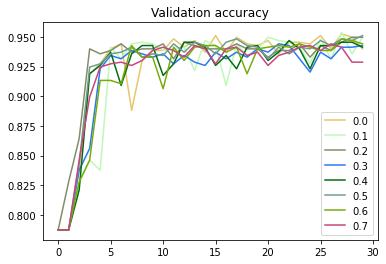

In [102]:
labels = []
for i in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    labels.append(i)

for i in range(len(accuracies)):
    r = np.random.rand()
    b = np.random.rand()
    g = np.random.rand()
    color = (r, g, b)
    epochs = range(len(accuracies[i]))
    plt.plot(epochs, val_accuracies[i], label='Validation accuracy', c=color)
    plt.legend(labels)
    plt.title('Validation accuracy')

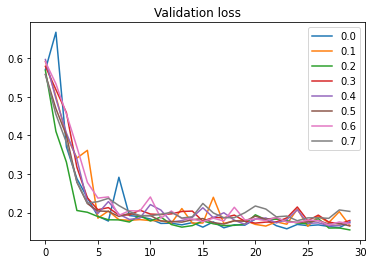

In [103]:
for i in range(len(accuracies)):
    r = np.random.rand()
    b = np.random.rand()
    g = np.random.rand()
    color = (r, g, b)
    epochs = range(len(accuracies[i]))
    plt.plot(epochs, val_losses[i], label='Validation loss')
    plt.legend(labels)
    plt.title('Validation loss')

To conclude on this part I decided to use a dropout of 20% that gives the best results.

Let's now try our final structure with images of myself.

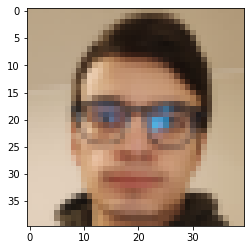

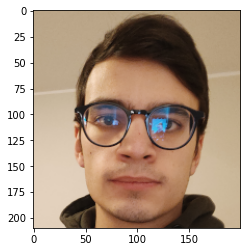

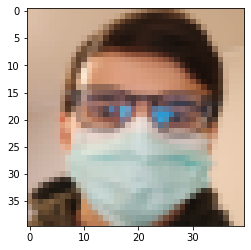

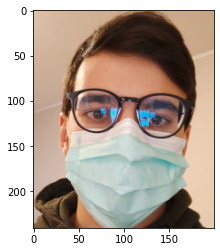

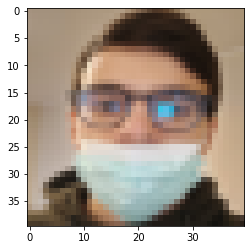

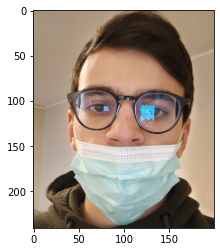

In [115]:
noMask = image.imread("no_mask.png")
mask = image.imread("mask.png")
notWell = image.imread("not_well.png")

noMaskResize = resize(noMask[...,:3], (IMAGE_SIZE, IMAGE_SIZE))
maskResize = resize(mask[...,:3], (IMAGE_SIZE, IMAGE_SIZE))
notWellResize = resize(notWell[...,:3], (IMAGE_SIZE, IMAGE_SIZE))

plt.imshow(noMaskResize)
plt.show()
plt.imshow(noMask)
plt.show()

plt.imshow(maskResize)
plt.show()
plt.imshow(mask)
plt.show()

plt.imshow(notWellResize)
plt.show()

plt.imshow(notWell)
plt.show()

noMaskResize = noMaskResize.astype('float32')
noMaskResize = noMaskResize / 255.
maskResize = maskResize.astype('float32')
maskResize = maskResize / 255.
notWellResize = notWellResize.astype('float32')
notWellResize = notWellResize / 255.

In [106]:
train_X = images_np[:splitSize]
train_Y = labels_np[:splitSize]
test_X = images_np[splitSize:]
test_Y = labels_np[splitSize:]

train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

batch_size = 30
epochs = 30
num_classes = 3

maskModel = Sequential()
maskModel.add(Conv2D(16, kernel_size=(5, 5),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
maskModel.add(MaxPooling2D((2, 2)))
maskModel.add(Dropout(0.2))

maskModel.add(Conv2D(32, (5, 5), activation='relu'))
maskModel.add(MaxPooling2D(pool_size=(2, 2)))
maskModel.add(Dropout(0.2))

maskModel.add(Flatten())
maskModel.add(Dense(512, activation='relu'))
maskModel.add(Dropout(0.2))
maskModel.add(Dense(num_classes, activation='softmax'))

maskModel.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
maskModelTrain = maskModel.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))



Epoch 1/30
96/96 [==============================] - 3s 23ms/step - loss: 0.7152 - accuracy: 0.7401 - val_loss: 0.5879 - val_accuracy: 0.7874
Epoch 2/30
96/96 [==============================] - 2s 20ms/step - loss: 0.6030 - accuracy: 0.7745 - val_loss: 0.4699 - val_accuracy: 0.7874
Epoch 3/30
96/96 [==============================] - 2s 20ms/step - loss: 0.4587 - accuracy: 0.8045 - val_loss: 0.3952 - val_accuracy: 0.8336
Epoch 4/30
96/96 [==============================] - 2s 22ms/step - loss: 0.3722 - accuracy: 0.8472 - val_loss: 0.2687 - val_accuracy: 0.9245
Epoch 5/30
96/96 [==============================] - 2s 20ms/step - loss: 0.2817 - accuracy: 0.9129 - val_loss: 0.2672 - val_accuracy: 0.8993
Epoch 6/30
96/96 [==============================] - 2s 22ms/step - loss: 0.2381 - accuracy: 0.9182 - val_loss: 0.2035 - val_accuracy: 0.9329
Epoch 7/30
96/96 [==============================] - 2s 22ms/step - loss: 0.2074 - accuracy: 0.9339 - val_loss: 0.2008 - val_accuracy: 0.9315
Epoch 8/30
96

# test = np.array([noMaskResize, maskResize, notWellResize])
testHotEncoder = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
values = maskModel.predict(test, batch_size=1, verbose=0)
for value in values:
    print(np.argmax(value))

As we could see here the detection is perfect for the two first pictures (with and without mask), but for the last class our CNN still has got problems and labels it as "with a mask". The problem is due to the fact that there's not much differences between the class 1 and 2 and that we would maybe need another method to detect it more precisely.

## ***9. Conclusion***

To conclude on this mini-project, I could have learned how to setup a CNN and find the best architecture in relation with the given entries. There's still maybe some elements to check to improve it even more like the step of preprocessing of the images, maybe see if the size of images or the depth of it would influence the results.
